In [7]:
import os
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

In [8]:
def read_file(filename, columns=None, **kwargs):
    print(filename)
    load_extension = os.path.splitext(filename)[-1]
    if load_extension == ".parquet":
        return pd.read_parquet(filename, columns=columns,**kwargs)
    elif load_extension == ".csv":
        return pd.read_csv(filename, usecols=columns, **kwargs)

In [9]:
fpath = '/local-scratch/nigam/projects/lguo/temp_ds_shift_robustness/clmbr/cohorts/admissions/cohort/'
df = read_file(f"{fpath}/cohort_split.parquet",engine='pyarrow')
df['admission_year']=df['admit_date'].dt.year
df = df.query("admission_year>2008")

/local-scratch/nigam/projects/lguo/temp_ds_shift_robustness/clmbr/cohorts/admissions/cohort//cohort_split.parquet


In [10]:
# Confirm that each person_id is unique
print(
    df.shape[0],
    df['person_id'].nunique(),
)

211230 211230


In [12]:
df['gender_female'] = np.where(df['gender_concept_name']=='FEMALE',1,0)
df['gender_male'] = np.where(df['gender_concept_name']=='MALE',1,0)
df['race_white'] = np.where(df['race_eth']=='White',1,0)
df['race_other'] = np.where(df['race_eth']=='White',0,1)

In [13]:
for var in ['admission_year']:
    df_agg = df.groupby(var).agg(
        subject_count = ('person_id', 'count'),
        age_mean = ('age_in_years','mean'),
        age_std = ('age_in_years','std'),
        gender_F = ('gender_female','sum'),
        gender_M = ('gender_male','sum'),
        race_W = ('race_white','sum'),
        race_O = ('race_other','sum'),
        mortality = ('hospital_mortality','sum'),
        los_7 = ('LOS_7','sum'),
        readmission_30 = ('readmission_30','sum'),
        icu = ('icu_admission','sum'),
        subject_count_readmission = ('readmission_30','count'),
    ).reset_index().round(2)

    df_agg['gender_F_perc'] = df_agg['gender_F']/df_agg['subject_count']*100
    df_agg['gender_M_perc'] = df_agg['gender_M']/df_agg['subject_count']*100
    df_agg['race_W_perc'] = df_agg['race_W']/df_agg['subject_count']*100
    df_agg['race_O_perc'] = df_agg['race_O']/df_agg['subject_count']*100
    df_agg['mortality_perc'] = df_agg['mortality']/df_agg['subject_count']*100
    df_agg['los_7_perc'] = df_agg['los_7']/df_agg['subject_count']*100
    df_agg['readmission_30_perc'] = df_agg['readmission_30']/df_agg['subject_count_readmission']*100
    df_agg['icu_perc'] = df_agg['icu']/df_agg['subject_count']*100

    df_agg['Age'] = df_agg['age_mean'].apply('{:.0f}'.format)+'±'+df_agg['age_std'].apply('{:.0f}'.format)+''

    df_agg['Gender (Female)'] = df_agg['gender_F'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['gender_F_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['Gender (Male)'] = df_agg['gender_M'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['gender_M_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['Race (White)'] = df_agg['race_W'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['race_W_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['Race (Other)'] = df_agg['race_O'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['race_O_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['In-Hospital Mortality'] = df_agg['mortality'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['mortality_perc'].apply('{:.0f}'.format)+'%)'
    
    df_agg['LOS >7 Days'] = df_agg['los_7'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['los_7_perc'].apply('{:.0f}'.format)+'%)'

    df_agg['Readmission 30 Days'] = df_agg['readmission_30'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['readmission_30_perc'].apply('{:.0f}'.format)+'%)'
    
    df_agg['ICU Admission'] = df_agg['icu'].apply(
        '{:.0f}'.format
    ) +' ('+df_agg['icu_perc'].apply('{:.0f}'.format)+'%)'

    df_agg = df_agg[['subject_count',var,'Age','Gender (Female)','Gender (Male)','Race (White)','Race (Other)','In-Hospital Mortality','LOS >7 Days','Readmission 30 Days','ICU Admission']]
    df_agg = df_agg.melt(id_vars=var)
    df_agg = df_agg.pivot(columns = var, values = 'value', index = 'variable')
    df_agg = df_agg.reindex(labels = [
        'subject_count',
        'Age',
        'Gender (Female)',
        'Gender (Male)',
        'Race (White)', 
        'Race (Other)',
        'In-Hospital Mortality',
        'LOS >7 Days',
        'Readmission 30 Days',
        'ICU Admission'
    ])
    display(df_agg)

admission_year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
variable,,,,,,,,,,,,,
subject_count,12727,12930,13104,13136,13117,15235,17241,16980,17198,21187,22514,22352,13509
Age,57±18,57±18,57±18,57±18,57±18,53±19,52±19,52±19,53±19,53±20,53±20,53±20,54±20
Gender (Female),6572 (52%),6579 (51%),6767 (52%),6576 (50%),6668 (51%),8820 (58%),10483 (61%),10310 (61%),10269 (60%),12874 (61%),13556 (60%),13234 (59%),8010 (59%)
Gender (Male),6154 (48%),6351 (49%),6337 (48%),6559 (50%),6448 (49%),6414 (42%),6757 (39%),6670 (39%),6929 (40%),8313 (39%),8956 (40%),9116 (41%),5496 (41%)
Race (White),7054 (55%),8106 (63%),8091 (62%),7848 (60%),7585 (58%),8092 (53%),8620 (50%),8174 (48%),8328 (48%),10164 (48%),10866 (48%),10101 (45%),5908 (44%)
Race (Other),5673 (45%),4824 (37%),5013 (38%),5288 (40%),5532 (42%),7143 (47%),8621 (50%),8806 (52%),8870 (52%),11023 (52%),11648 (52%),12251 (55%),7601 (56%)
In-Hospital Mortality,267 (2%),317 (2%),337 (3%),337 (3%),340 (3%),321 (2%),345 (2%),345 (2%),335 (2%),402 (2%),379 (2%),459 (2%),249 (2%)
LOS >7 Days,2680 (21%),2718 (21%),2719 (21%),2739 (21%),2703 (21%),2939 (19%),3065 (18%),3364 (20%),3263 (19%),3767 (18%),4078 (18%),4300 (19%),2709 (20%)
Readmission 30 Days,659 (5%),767 (6%),708 (6%),681 (5%),689 (5%),789 (5%),819 (5%),778 (5%),777 (5%),1035 (5%),1132 (5%),1111 (5%),630 (5%)


##### Proportion of admit_date and discharge_date that are at midnight

In [14]:
admit_diff = (df.admit_date - pd.to_datetime(df.admit_date.dt.date)) / np.timedelta64(1,'h')
discharge_diff = (df.discharge_date - pd.to_datetime(df.discharge_date.dt.date)) / np.timedelta64(1,'h')
print(
    f"admit_time at midnight [%]: {round(np.mean(admit_diff==0)*100,4)}\n"
    f"discharge_time at midnight [%]: {round(np.mean(admit_diff==0)*100,4)}"
)

admit_time at midnight [%]: 0.0473
discharge_time at midnight [%]: 0.0473


##### LOS distribution in minutes

In [19]:
idf = df[~df['LOS_7'].isnull()]
los = round((idf.discharge_date - idf.admit_date) / np.timedelta64(1,'m'))

(0.0, 10000.0)

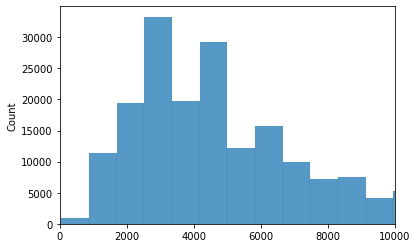

In [20]:
ax = sns.histplot(los,kde=False,bins=1000)
ax.set_xlim([0,10000])

In [21]:
min(los)

42.0

In [22]:
len(np.where(los<60)[0])

1

##### Prevalence by Year and Split

In [23]:
folds = df['fold_id'].unique().tolist()
years = df['admission_year'].unique().tolist()
tasks = ['hospital_mortality','LOS_7','readmission_30','icu_admission']
df_v = pd.DataFrame(columns=['year','fold','task','count','perc'])
c=0
for year in years:
    for fold in folds:
        for task in tasks:
            c+=1
            sample = df.query(f"{task}_fold_id==@fold and admission_year==@year")
            df_v.loc[c,:]=[year,fold,task,sample[task].sum(),sample[task].mean()]

In [24]:
df_v.pivot(index=['task','fold'],columns='year',values=['perc'])

perc                                          \
year                         2009      2010      2011      2012      2013   
task               fold                                                     
LOS_7              1     0.222032  0.199778  0.203408  0.200878  0.206498   
                   2     0.196787  0.207915  0.210411  0.202186  0.211655   
                   3     0.219359  0.216834  0.212121  0.213545  0.202414   
                   4     0.197263  0.204469  0.216795  0.217605  0.203194   
                   5     0.210286  0.228747  0.200658  0.218252  0.209863   
                   test  0.221097  0.203222  0.208611  0.212788  0.220174   
                   val   0.233405  0.223145  0.210958  0.205325   0.20082   
hospital_mortality 1     0.026256  0.022198  0.026388  0.026894  0.028634   
                   2      0.02467  0.021739  0.024658  0.021311  0.024189   
                   3     0.021191  0.019509  0.021488  0.030038  0.026879   
                   4     0.021095  0.027374  0.021954  0.024604   0.02478   
                   5     0.022286  0.028523  0.027961  0.028037  0.032329   
                   test  0.013852  0.028067  0.029728  0.024041   0.02509   
                   val   0.020878  0.025428  0.028674  0.026114  0.021516   
icu_admission      1     0.014586  0.033701  0.032759  0.025952  0.028258   
                   2     0.013411  0.025806  0.031375  0.021143  0.026012   
                   3     0.008178  0.025791  0.025258  0.034384  0.027168   
                   4     0.006952  0.024547  0.022465  0.025244   0.03291   
                   5     0.007528  0.023991  0.025877  0.024207  0.031432   
                   test  0.008667   0.02553  0.025188  0.029443  0.029095   
                   val   0.007104    0.0213  0.021494  0.022496   0.02694   
readmission_30     1     0.045214  0.060865  0.054453  0.055493  0.057987   
                   2     0.054309  0.071429  0.058061  0.054871  0.059255   
                   3     0.061547  0.052422  0.044068  0.058192  0.046893   
                   4     0.049065  0.056615  0.062641  0.059786  0.045274   
                   5     0.055132  0.063621  0.056593  0.054039  0.058556   
                   test  0.060738  0.072542  0.057825   0.05313  0.057368   
                   val   0.052141  0.053533  0.058824  0.042194  0.056286   

                                                                           \
year                         2014      2015      2016      2017      2018   
task               fold                                                     
LOS_7              1      0.19717  0.166736  0.215976  0.201502  0.163507   
                   2     0.204072  0.173149  0.206926  0.193899  0.188136   
                   3     0.190858  0.182272  0.191885  0.176618  0.177228   
                   4     0.188831   0.18432  0.203727  0.196234   0.17697   
                   5     0.203975  0.193656  0.195505  0.194398  0.185739   
                   test  0.183179  0.174572  0.192976  0.176791  0.183027   
                   val   0.193307  0.178599  0.188933  0.197035  0.177215   
hospital_mortality 1     0.021698  0.017133  0.023669  0.019191  0.017265   
                   2     0.026042   0.02133  0.022382  0.021312      0.02   
                   3     0.021678  0.016646  0.019442  0.018789  0.023043   
                   4      0.02461   0.02377  0.014401  0.022176  0.019361   
                   5     0.021297  0.018364  0.022053  0.021321  0.020374   
                   test  0.017613  0.022939  0.020916  0.019081  0.022166   
                   val   0.016292  0.020623  0.020158  0.015607  0.011709   
icu_admission      1      0.02801  0.023458  0.034331   0.02459  0.022285   
                   2     0.028501  0.029767  0.025821  0.031934  0.029349   
                   3     0.018182   0.02203  0.027815  0.023367  0.032419   
                   4     0.030973  0.022068   0.03114  0.019948  0.035269   
                   5    